# Fooled colored MNIST (Try to put more focus on colors instead of the shape of the digits)
The idea is to create a model, which should be able to asses, if the digit in the image is a low or a high number. The image dataset of colored digits is divided into three parts namely the train, validation and test datasets. In the train and validatin datasets, the low numbers are colored in red and the high numbers are colored in green. In the test dataset, the colors are random. If the model is able to recognize the value of the digits from it's shape, the performance should be nearly equal as the performance on the train and validation datasets. The hypothesis is, that the model will learn to separate low from high digits based on their color and therefore will fail on the test dataset.

## Setup environment

In [1]:
import torch

torch.cuda.empty_cache()

In [2]:
# basic modules
import numpy as np
import matplotlib.pyplot as plt
import sys

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models as torch_models
from torchvision import __version__ as torchvision_version

%load_ext autoreload
%autoreload 2

print("Torch version:", torch.__version__)

Torch version: 1.13.0a0+d0d6b1f


In [3]:
# include plots in notebook
%matplotlib inline

In [4]:
# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision_version)

!nvidia-smi

Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Tue Jan 24 04:43:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   37C    P0    69W / 350W |  32200MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+--

## Prepare dataset

In [5]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *
from utils.mnist_general import *

# dataset parameters
DATASET_BATCH_SIZE = 128
DATASET_SHUFFLE = True
DATASET_TEST_FOOL_RANDOM_COLORS = True

# fileconfig
DATA_DIR='/home/patrick.koller/masterthesis/mnt_data/data'
MODEL_BACKUP_FILENAME = "standalone_resnet50_unbiased"

In [6]:
import clip

model, preprocess = clip.load("RN50")

MNIST dataset already exists


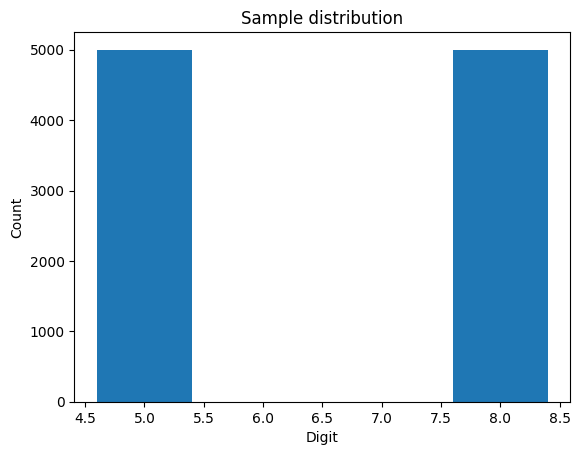

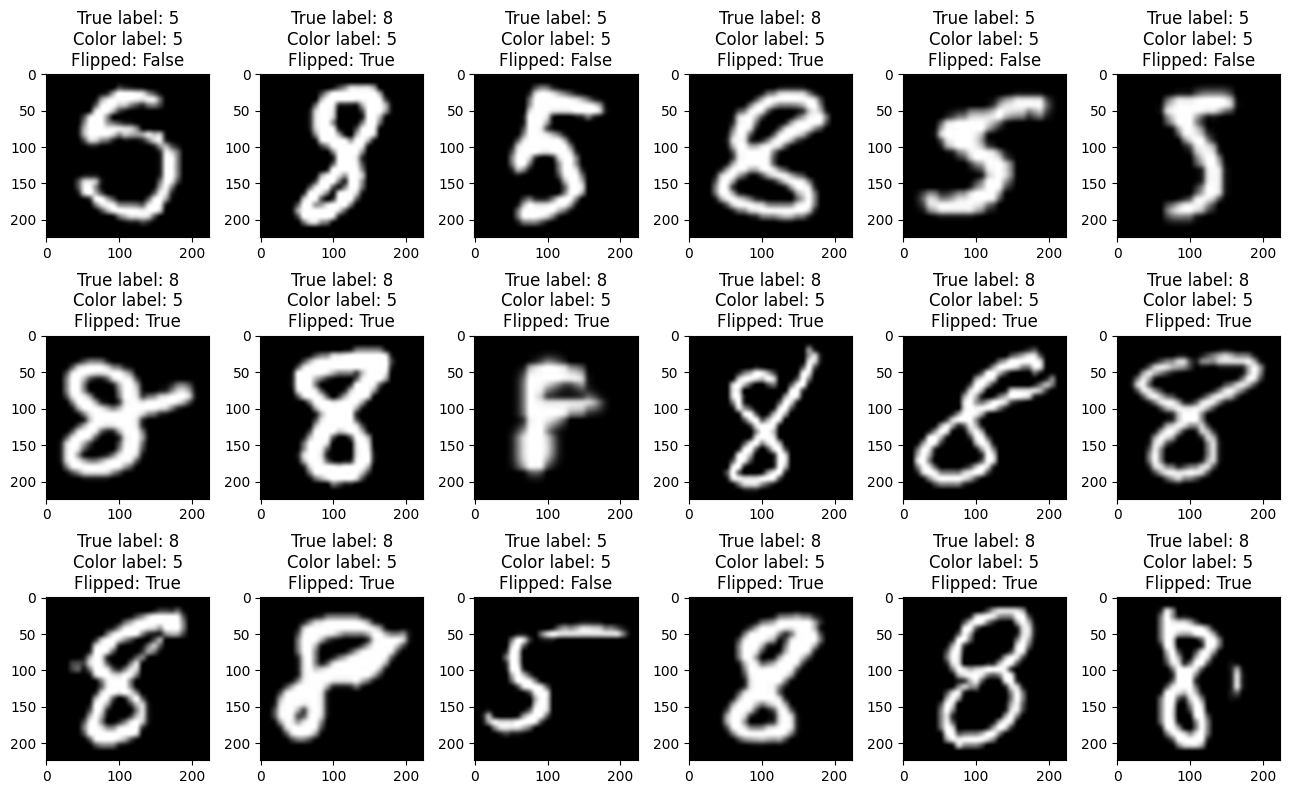

In [7]:
# create and select training dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='train',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='train',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
train_set = DatasetMNIST(root=DATA_DIR,
                            env='train',
                            color=False,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            test_fool_random=DATASET_TEST_FOOL_RANDOM_COLORS,
                            transform= transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

digit_distribution(train_set)
plot_digits(train_set, preprocess)

MNIST dataset already exists


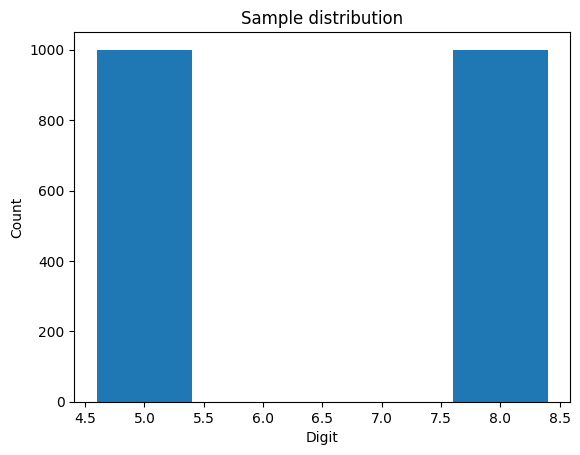

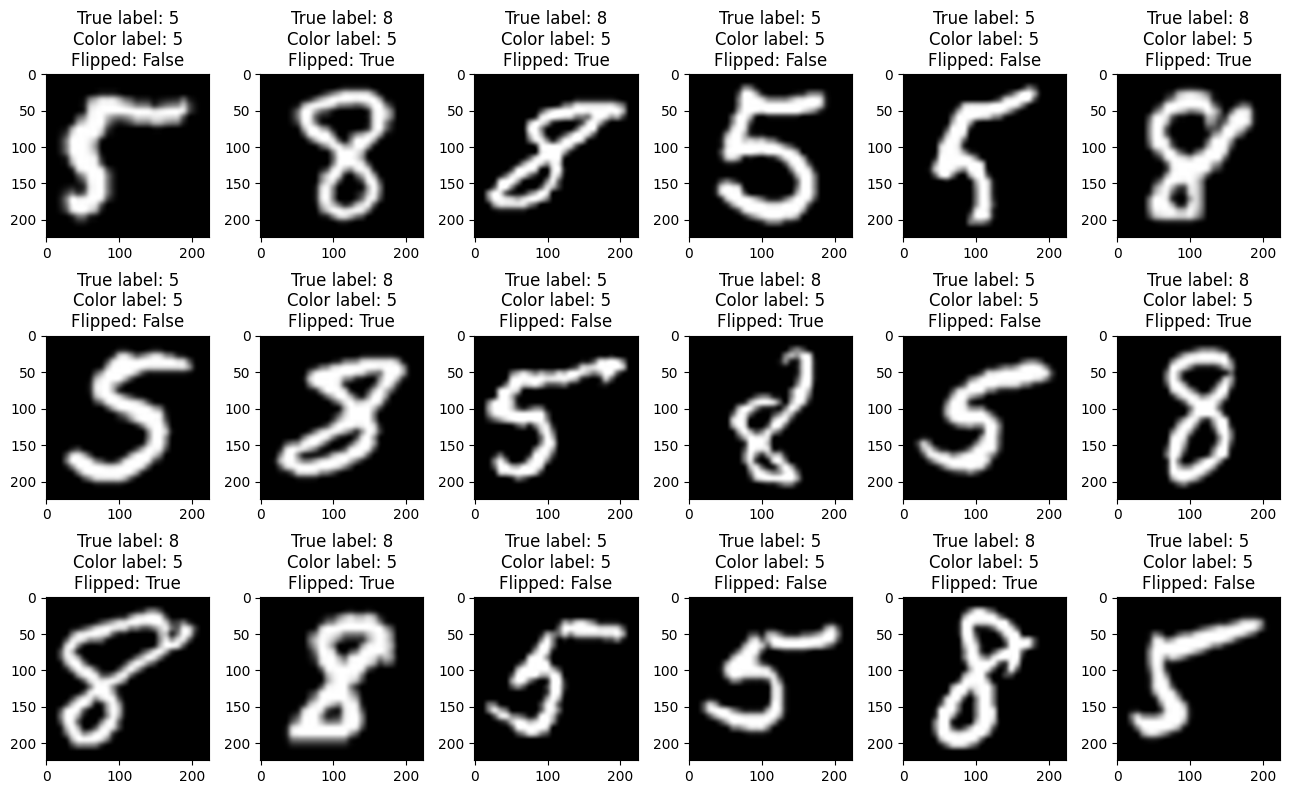

In [8]:
# create and select test dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='test',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='test',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
test_set = DatasetMNIST(root=DATA_DIR,
                            env='test',
                            color=False,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            test_fool_random=DATASET_TEST_FOOL_RANDOM_COLORS,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

digit_distribution(test_set)
plot_digits(test_set, preprocess)

MNIST dataset already exists


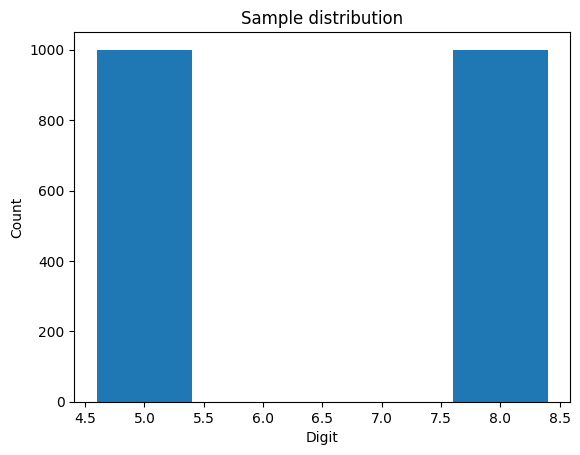

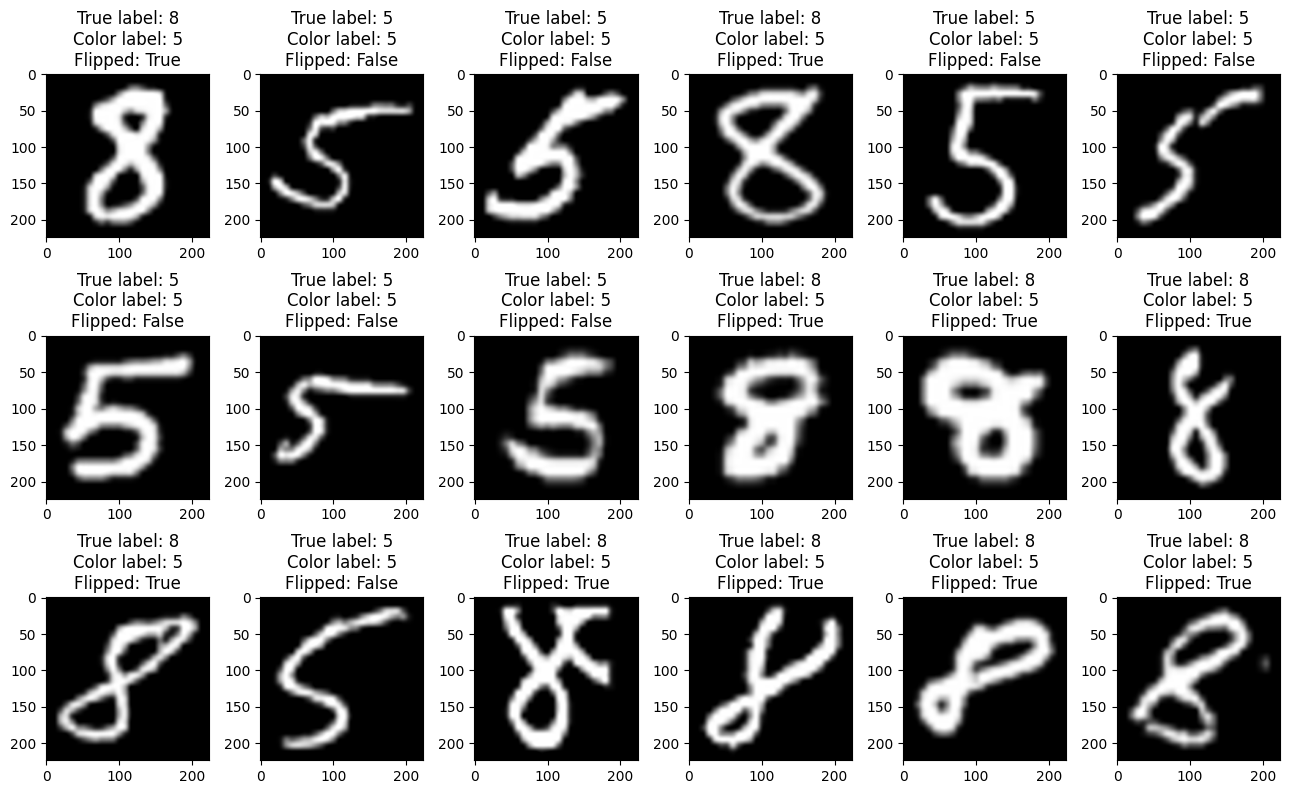

In [9]:
# create and select test_fool dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='test_fool',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='test_fool',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
test_set_fool = DatasetMNIST(root=DATA_DIR,
                            env='test_fool',
                            color=False,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            test_fool_random=DATASET_TEST_FOOL_RANDOM_COLORS,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_fool_loader = torch.utils.data.DataLoader(dataset=test_set_fool,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

digit_distribution(test_set_fool)
plot_digits(test_set_fool, preprocess)

## Setup GPU (For number crunching)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
from pynvml import *

nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 34089730048
free     : 325320704
used     : 33764409344


## Train network

In [12]:
# file config
model_path, history_path, log_path = get_model_paths(MODEL_BACKUP_FILENAME)

# paranoia
print(f"{model_path=}")
print(f"{history_path=}")
print(f"{log_path=}")

model_path='/mnt/data/patrick.koller/masterthesis/data/results/standalone_resnet50_unbiased.mdl'
history_path='/mnt/data/patrick.koller/masterthesis/data/results/standalone_resnet50_unbiased.hist'
log_path='/mnt/data/patrick.koller/masterthesis/data/results/standalone_resnet50_unbiased.log'


In [13]:
from sklearn.model_selection import KFold
import copy

def train_model(num_epochs=3, learning_rate=.00001, logfile="./model.log"):
    """
    Training procedure and performance measurement of the model.
    """
    history = {'train_w_backprop'   :   {'fold0'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold1'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold2'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold3'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold4'  : {'loss' : [],
                                                    'acc' : []}},
                
            'train'             :   {'fold0'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold1'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold2'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold3'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold4'  : {'loss' : [],
                                                    'acc' : []}},
                
            'validation'        :   {'fold0'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold1'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold2'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold3'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold4'  : {'loss' : [],
                                                    'acc' : []}},
                
            'test'              :   {'fold0'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold1'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold2'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold3'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold4'  : {'loss' : [],
                                                    'acc' : []}},
                
            'test_fool'         :   {'fold0'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold1'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold2'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold3'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold4'  : {'loss' : [],
                                                    'acc' : []}}
        }
    
        
    # delete existing log-file
    os.system(f"rm {logfile}")
    
    # setup model
    # https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights
    # model = torch_models.resnet50(pretrained=True)
    model = torch_models.resnet50(weights='IMAGENET1K_V2')
    for param in model.parameters():
        param.requires_grad = True
    # replace the last fully-connected layer
    # parameters of newly constructed modules have required_grad=True by default
    model.fc = nn.Linear(2048, 2)
    model = model.to(device)
    model.train()
    
    # create a model for each of the kfolds with same initial conditions
    KFOLDS = 5
    kfold = KFold(n_splits=KFOLDS, shuffle=True)
    models = []
    for i in range(KFOLDS):
        models.append(copy.deepcopy(model))
    del model
    
    # F.sigmoid (Map values between 0 and 1) + F.binary_cross_entropy
    # https://zhang-yang.medium.com/how-is-pytorchs-binary-cross-entropy-with-logits-function-related-to-sigmoid-and-d3bd8fb080e7
    # https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
    #criterion = F.binary_cross_entropy_with_logits #(input, target)
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_ids, test_ids) in enumerate(kfold.split(train_set)):
        
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
            
        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
                        train_set, 
                        batch_size=DATASET_BATCH_SIZE, sampler=train_subsampler)
        valloader   = torch.utils.data.DataLoader(
                        train_set,
                        batch_size=DATASET_BATCH_SIZE, sampler=val_subsampler)
        
        # setup optimizer
        optimizer = optim.Adam(models[fold].parameters(), lr=learning_rate)
        
        # train model for number of epochs
        for epoch in range(num_epochs):
            
            for phase in history.keys():
                
                # phase configuration
                if phase == 'train_w_backprop':
                    models[fold].train()
                    datasource = trainloader
                elif phase == "train":
                    models[fold].eval()
                    datasource = trainloader
                elif phase == "validation":
                    models[fold].eval()
                    datasource = valloader
                elif phase == "test":
                    models[fold].eval()
                    datasource = test_loader
                elif phase == "test_fool":
                    models[fold].eval()
                    datasource = test_fool_loader
                else:
                    raise NotImplementedError("Sorry, unknown phase!")

                # training to learn weights
                epoch_loss = 0.0
                running_corrects = 0
                label_counter = 0
                for inputs, _, low_high_lables, _ in datasource:
                    
                    # inference
                    inputs = inputs.to(device)
                    low_high_lables = low_high_lables.to(device)
                    if phase == 'train_w_backprop':
                        logits = models[fold](inputs)
                    else:
                        with torch.no_grad():
                            logits = models[fold](inputs)
                    
                    # sanity check: ensure only one unique max for next step
                    unique_max = (logits == torch.max(logits)).nonzero().shape == torch.Size([1, 2])
                    if (not unique_max):
                        print("Error: not unique max! Take first!")
                    
                    # prediction
                    preds = logits.argmax(dim=1)
                    running_corrects += torch.sum(preds == low_high_lables.data)
                    label_counter += low_high_lables.size()[0]
                    
                    # loss
                    batch_loss = criterion(logits, low_high_lables)
                    epoch_loss += batch_loss.item()

                    # training
                    if phase == 'train_w_backprop':
                        optimizer.zero_grad()   # Sets the gradients of all optimized torch.Tensor to zero.
                        batch_loss.backward()   # compute gradients
                        optimizer.step()        # Performs a single optimization step (parameter update)
                        
                epoch_acc = 100 * running_corrects.double() / label_counter
                
                # log performance summary
                summary = 'Model on fold {}: epoch {} loss: {:.4f}, acc: {:.4f} ({})'.format(fold,
                                                                                        epoch,
                                                                                        epoch_loss,
                                                                                        epoch_acc,
                                                                                        phase)
                
                print(summary)
                with open(logfile, "a") as f:
                    f.write(summary + "\n")
                
                history[phase]["fold"+str(fold)]['loss'].append(epoch_loss)
                history[phase]["fold"+str(fold)]['acc'].append(epoch_acc.cpu().item())

    # select best model based on validation score
    best_model_idx = 0
    highest_model_acc = 0
    for i in range(KFOLDS):
        if (history['validation']["fold"+str(i)]['acc'][-1] > highest_model_acc):
            highest_model_acc = history['validation']["fold"+str(i)]['acc'][-1]
            best_model_idx = i
            
    best_model = copy.deepcopy(models[best_model_idx])
    
    # cleanup GPU
    del inputs
    del low_high_lables
    del models
    torch.cuda.empty_cache()
    
    return best_model, history

In [14]:
import pickle

# 10 epochs over 1 fold take ~13 min
model, model_history = train_model(num_epochs=100, learning_rate=.00000015, logfile=log_path)

# sanity check
layer_requires_grad = []
for param in model.parameters():
    layer_requires_grad.append(param.requires_grad)
print(f"All layers retrained: {all(layer_requires_grad)}")

# freeze all layers (for safety)
for param in model.parameters():
    param.requires_grad = False
print(f"All layers freezed")

# save data
if True:
    pickle.dump(model, open(model_path, 'wb'))
    pickle.dump(model_history, open(history_path, 'wb'))

# cleanup
del model
del model_history
torch.cuda.empty_cache()

rm: cannot remove '/mnt/data/patrick.koller/masterthesis/data/results/standalone_resnet50_unbiased.log': No such file or directory


Model on fold 0: epoch 0 loss: 43.9314, acc: 48.6625 (train_w_backprop)
Model on fold 0: epoch 0 loss: 44.0085, acc: 46.4500 (train)
Model on fold 0: epoch 0 loss: 11.1745, acc: 47.3000 (validation)
Model on fold 0: epoch 0 loss: 11.1519, acc: 47.4500 (test)
Model on fold 0: epoch 0 loss: 11.1574, acc: 46.4000 (test_fool)


In [15]:
import pickle

# load data
if True:
    model_path, history_path, log_path = get_model_paths(MODEL_BACKUP_FILENAME)
    model = pickle.load(open(model_path, 'rb'))
    model_history = pickle.load(open(history_path, 'rb'))

## Assess performance

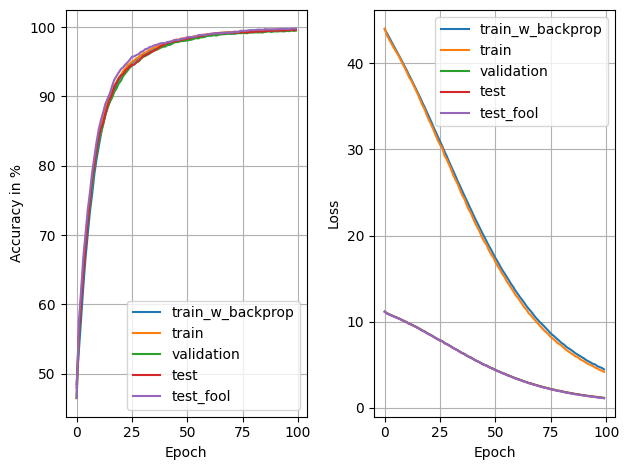

In [16]:
plot_history(model_history, show_points=False)

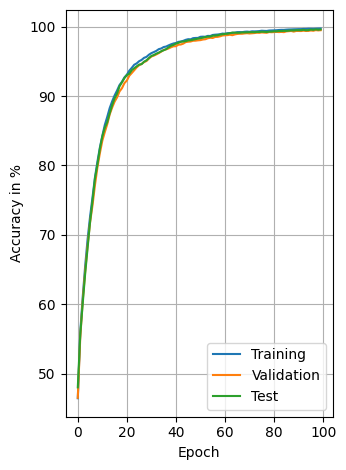

In [17]:
# plot for documentation with less distraction
plot_history(model_history, show_plots=['acc'], show_points=False,
             show_curves=['train', 'validation', 'test'],
             alternative_labels=['Training', 'Validation','Test'])

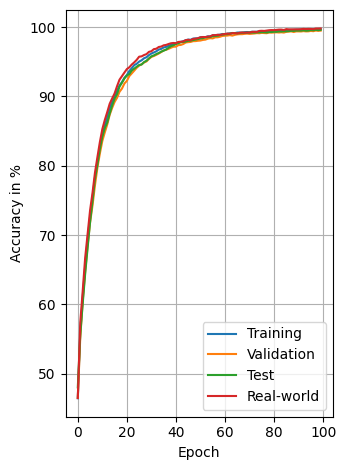

In [18]:
# plot for documentation with less distraction
plot_history(model_history, show_plots=['acc'], show_points=False,
             show_curves=['train', 'validation', 'test', 'test_fool'],
             alternative_labels=['Training', 'Validation', 'Test', 'Real-world'])

Batch accuracy: 100.0%


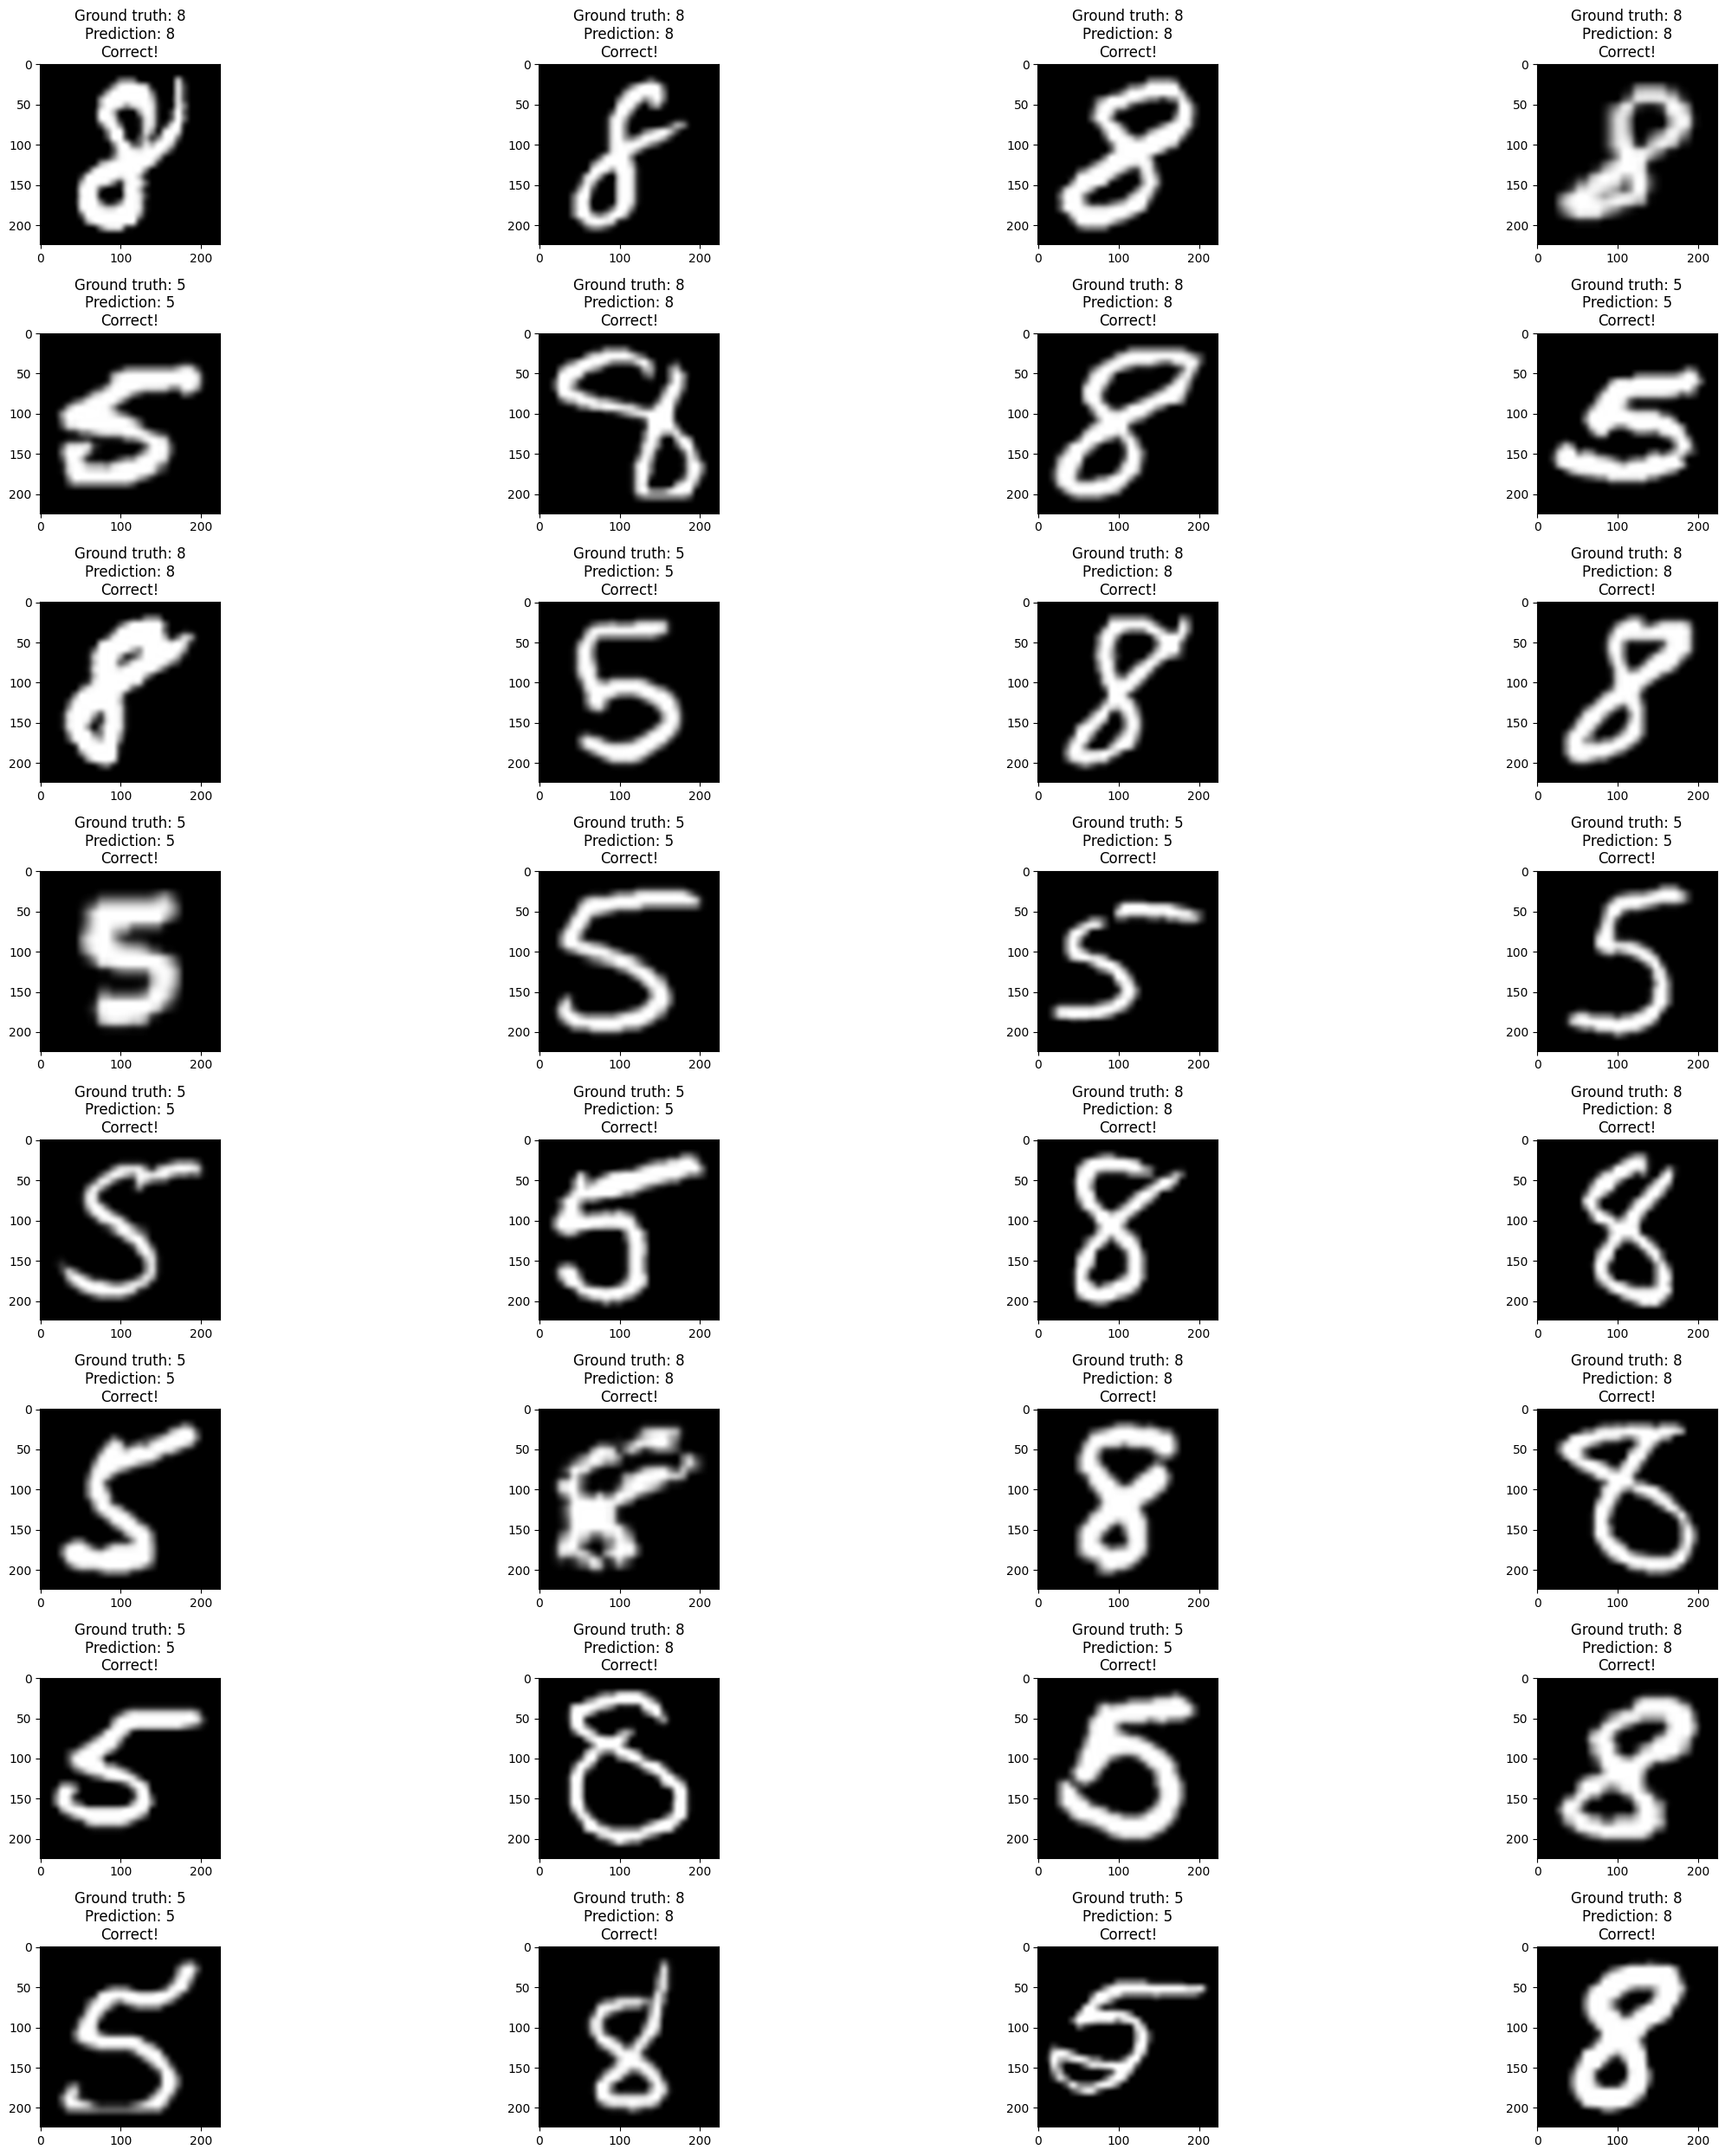

In [19]:
random_tests(train_loader, model, device, preprocess)

Batch accuracy: 99.21875%


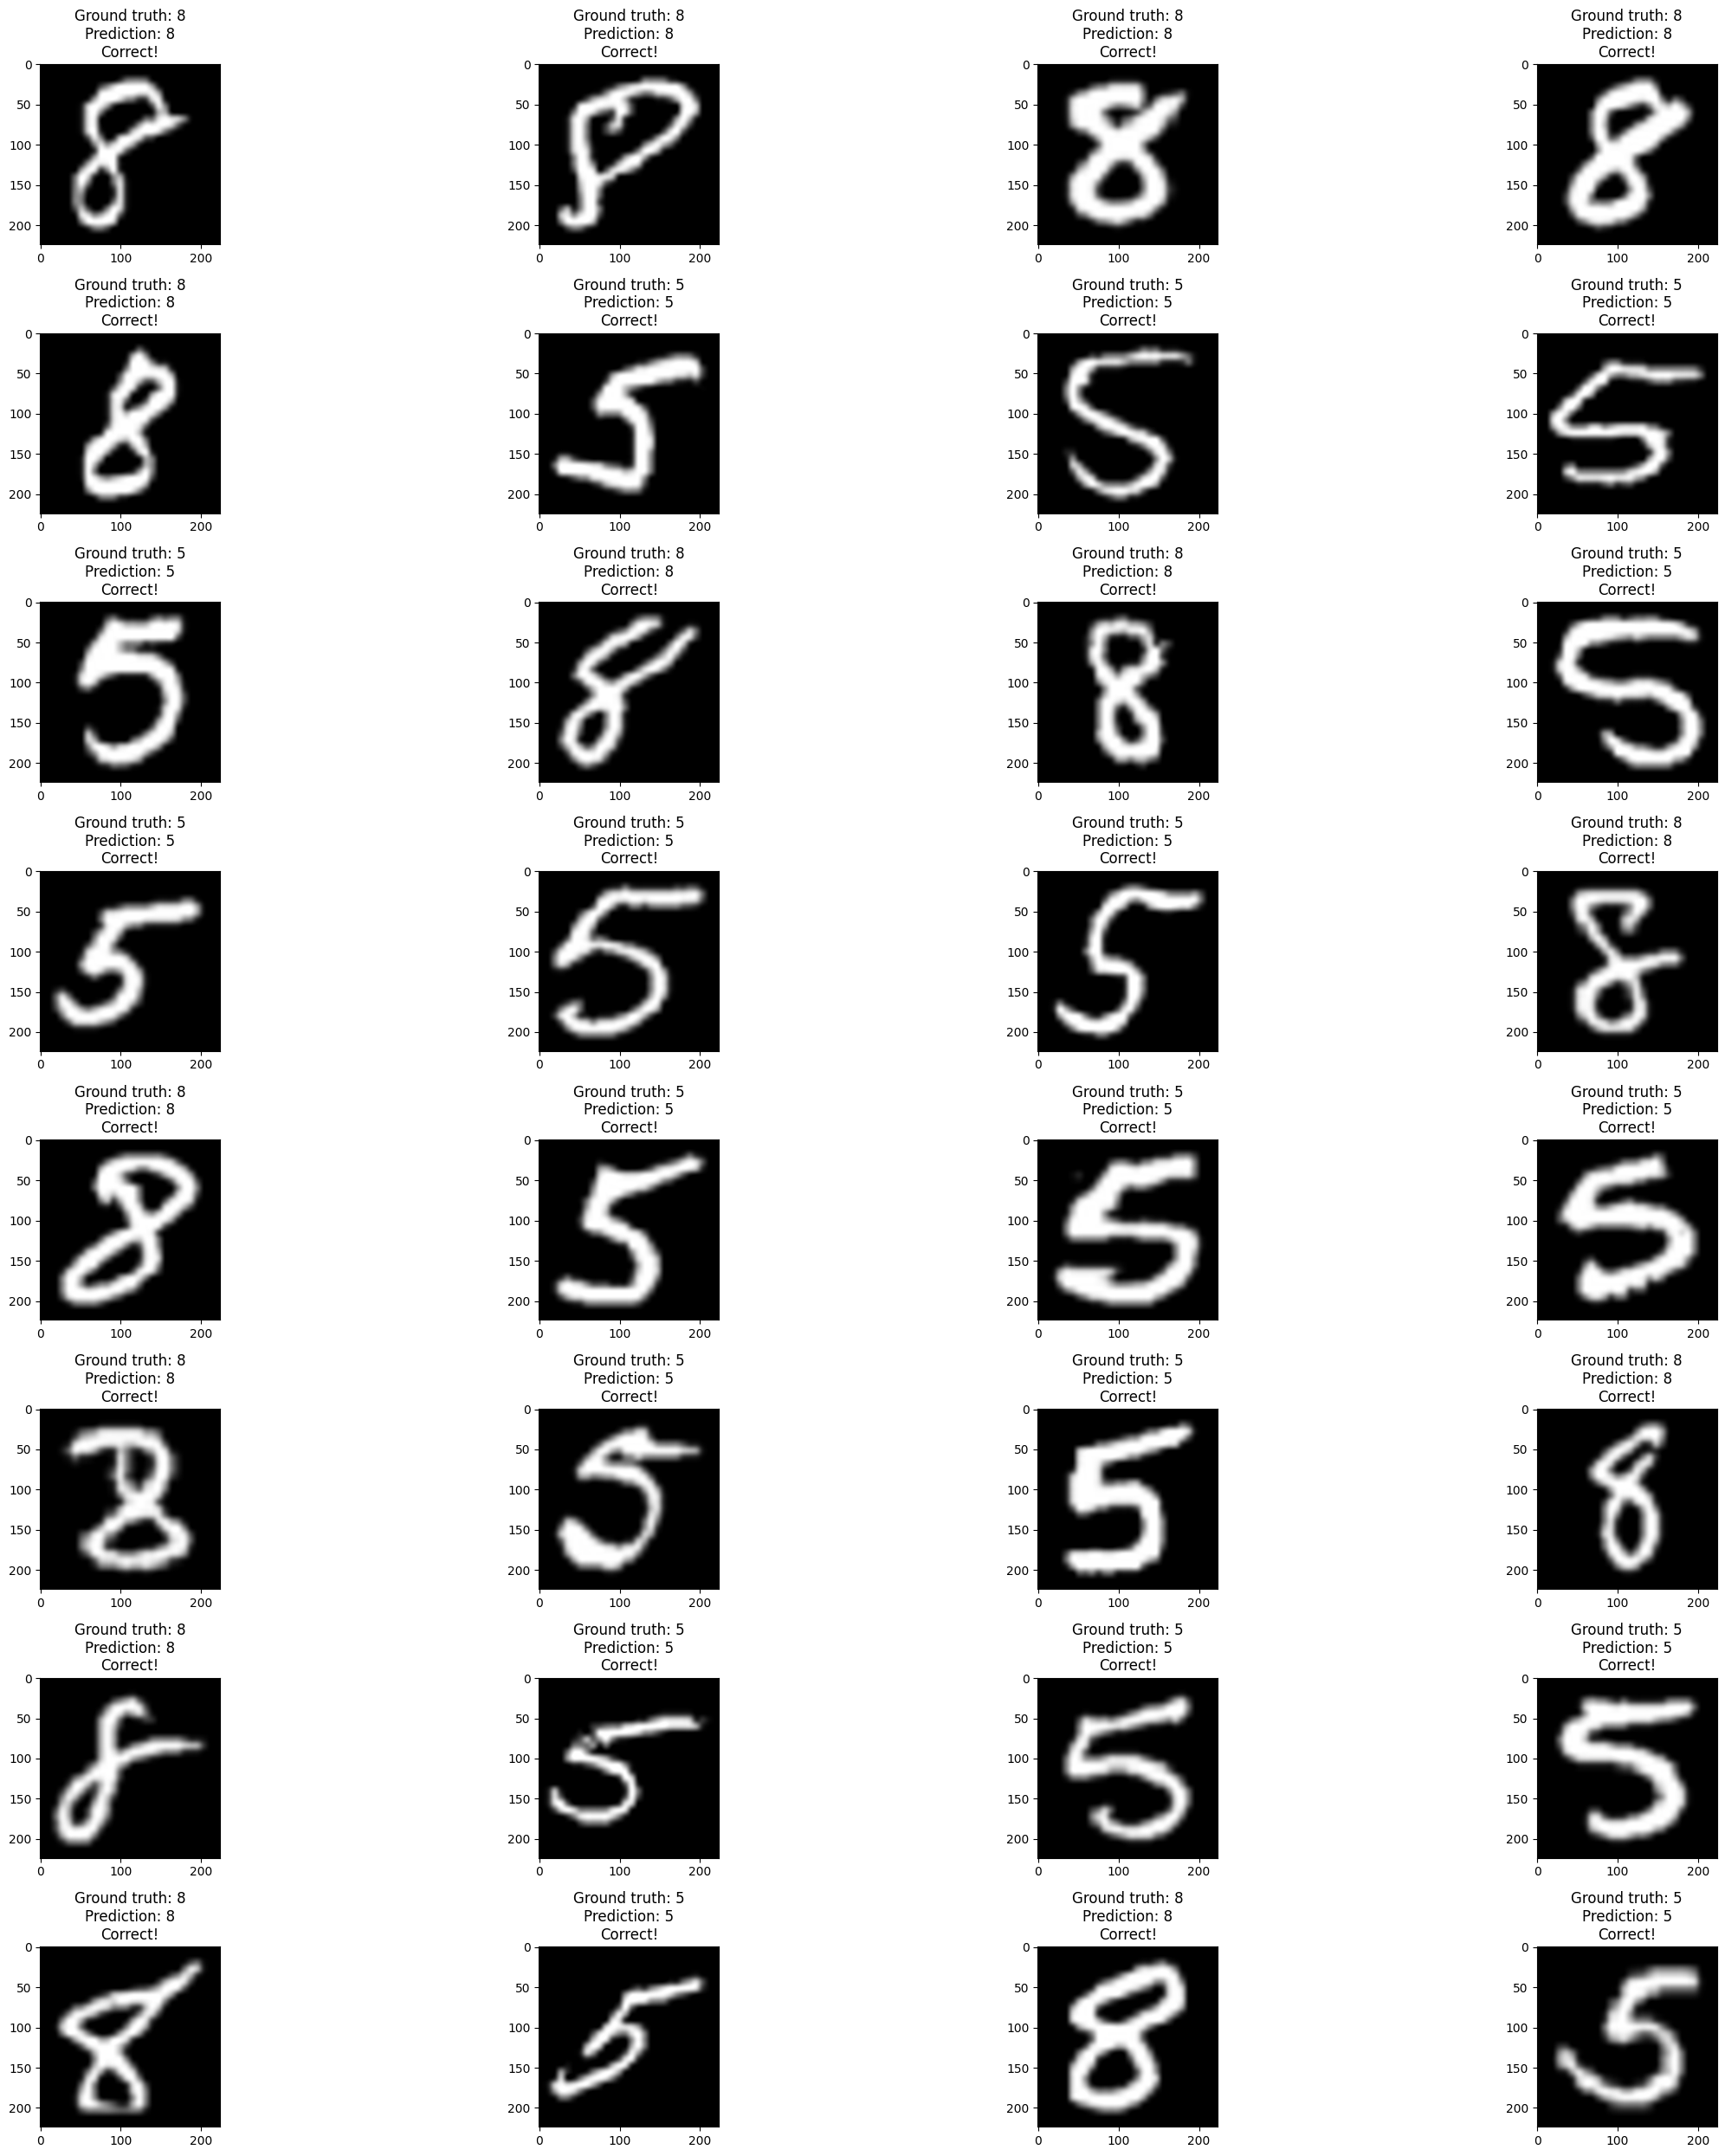

In [20]:
random_tests(test_loader, model, device, preprocess)

Batch accuracy: 100.0%


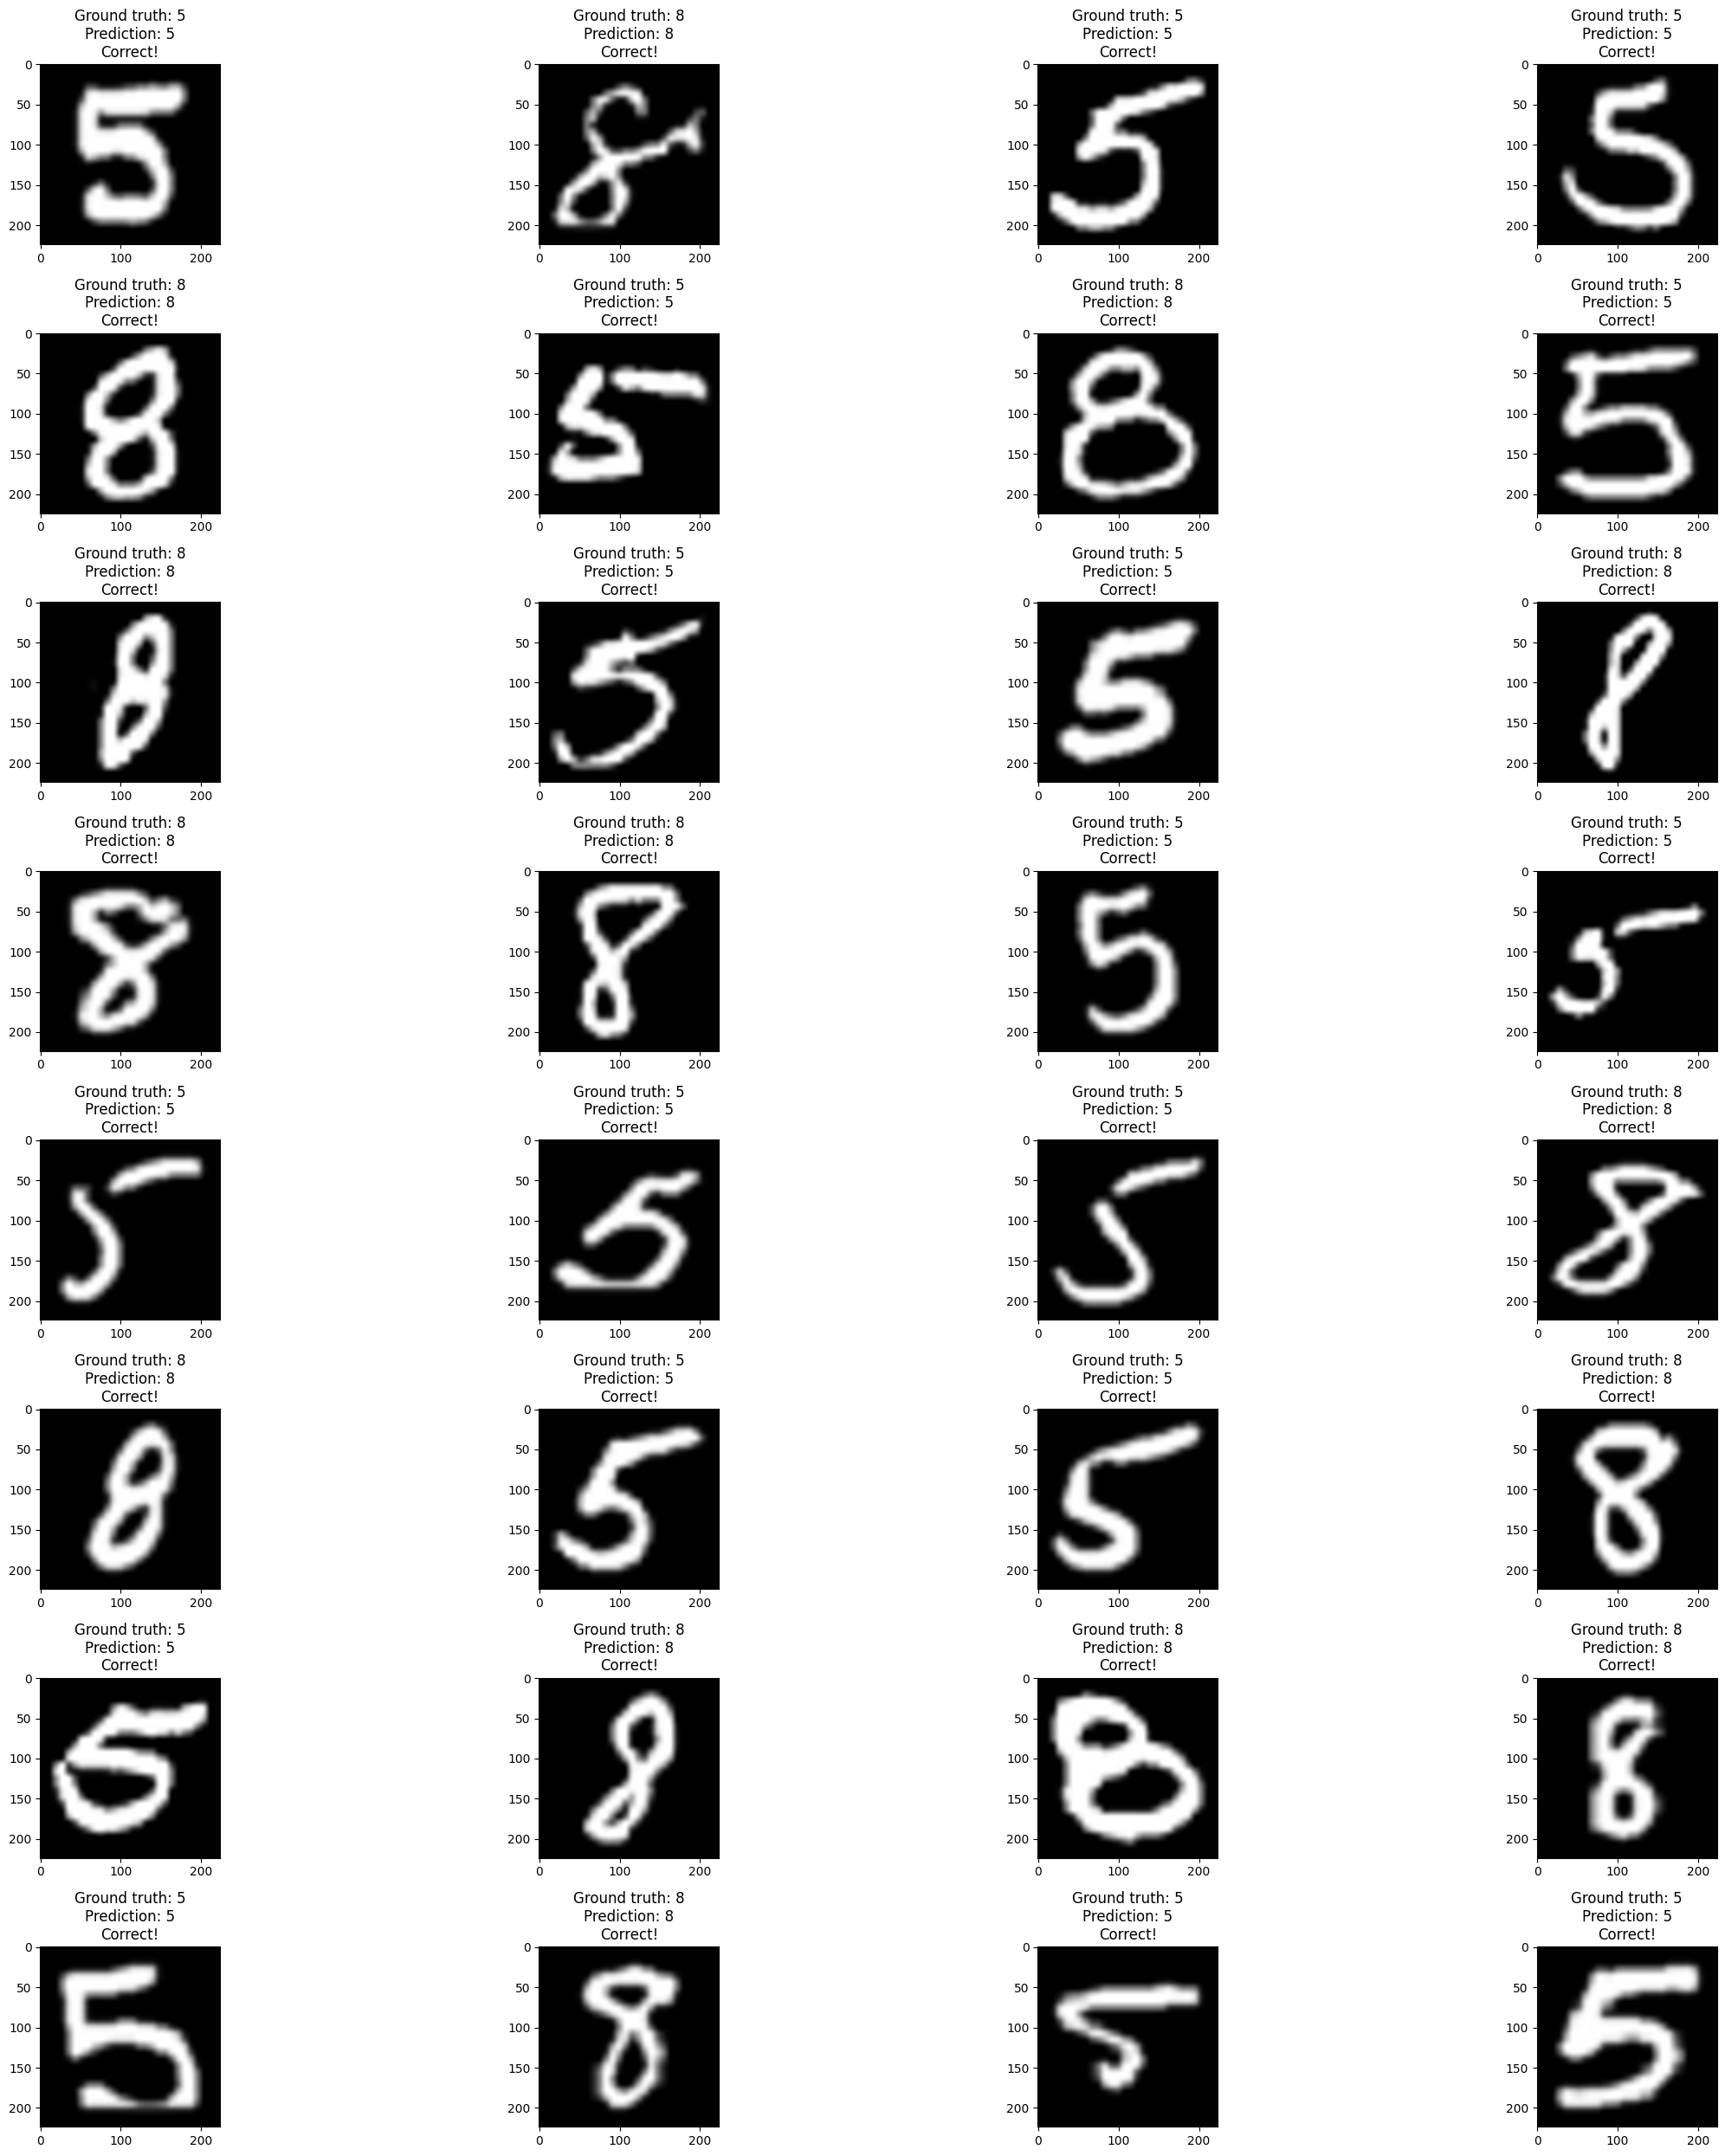

In [21]:
random_tests(test_fool_loader, model, device, preprocess)